# NLP Assignment
### Disaster prediction of tweets


By: Aditya Andra | Ani Afyan

Content:
1. Preprocessing
     1. Feature extraction and Text analysis
     2. Target correction
     3. Text cleaning
        
2. Bag of words, Baseline
     1. TF-IDF Vectorizer
     2. Baseline model
     3. Hyperparameter tuning
     4. POS as a feature
3. Advanced feature extraction, word embedding and modelling
     1. Tokenizing
     2. Removing stopwords
     3. Stemming
     4. Word2Vec
     5. Hyperparameter tuning
     6. SVM
     7. Submission
     
4. Pre-trained word embedding and modelling
     1. Glove
     2. SVM
     3. Neural Network

In [1]:
!pip install nltk
import nltk
nltk.download('punkt')  
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ani\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#Upload data
train = pd.read_csv('https://raw.githubusercontent.com/adia4/nlp-getting-started/master/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/adia4/nlp-getting-started/master/test.csv')
submission = pd.read_csv('https://raw.githubusercontent.com/adia4/nlp-getting-started/master/sample_submission.csv')


## 1. Preprocessing tweets
### A.Feature extraction and text analysis

Tweets are generally short, noisy and have unique lexical and semantic features that are different from other types of text. They normally include hashtags, mentions, links and abbreviations, apostrophes and other symbols which should be looked at and cleaned. 

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [0]:
train.isnull().any()
test.isnull().any()

id          False
keyword      True
location     True
text        False
dtype: bool

In [0]:
print('Number of unique categories: {}\n'.format(train.keyword.nunique()))
train.keyword.isnull().value_counts()


Number of unique categories: 221



False    7552
True       61
Name: keyword, dtype: int64

Almost 50% of location is missing and there are too many unique values so we find valid to drop the feature.

In [0]:
print('Number of unique categories: {}\n'.format(train.location.nunique()))
train.location.isnull().value_counts()

Number of unique categories: 3341



False    5080
True     2533
Name: location, dtype: int64

Analyzing most common keywords per each class, we can see that although some of those keywords are represented both in disaster and non disaster tweets, they show a specific lexical context as opposed to general use words. So keyword can be an important feature.

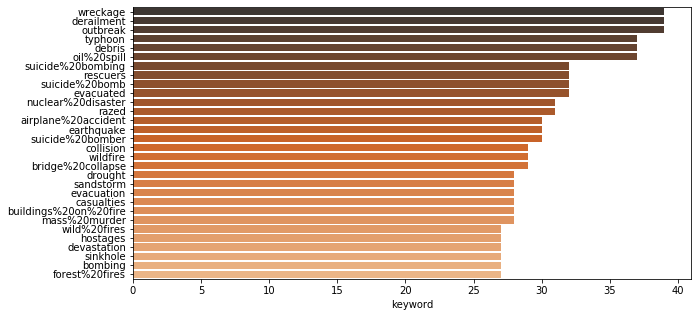

In [3]:
#Most common keywords per class disaster
plt.figure(figsize=(10,5))
disaster_keywords = train.loc[train.target == 1]['keyword'].value_counts()
sns.barplot(y=disaster_keywords[0:30].index, x=disaster_keywords[0:30], palette = "Oranges_d", orient ="h")


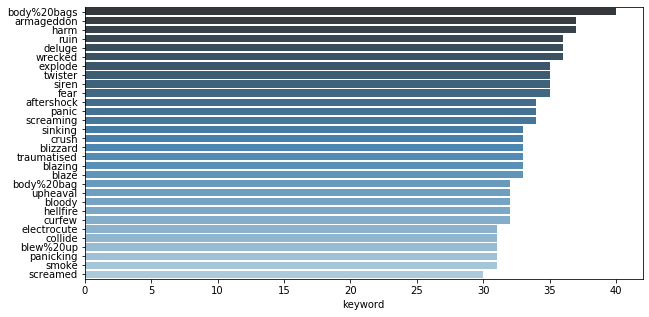

In [4]:
#Most common keywords per class non disaster
plt.figure(figsize=(10,5))
nondisaster_keywords = train.loc[train.target == 0]['keyword'].value_counts()
sns.barplot(y=nondisaster_keywords[0:30].index, x=nondisaster_keywords[0:30], palette = "Blues_d", orient ="h")


One of the features we should also look at is the number of words in each tweet. The basic expectation behind is to see if disaster tweets, for bearing more negative character contain a lessor amount words as opposed to the positive tweets. However, we could not find any distinctive difference between number of words in each class.

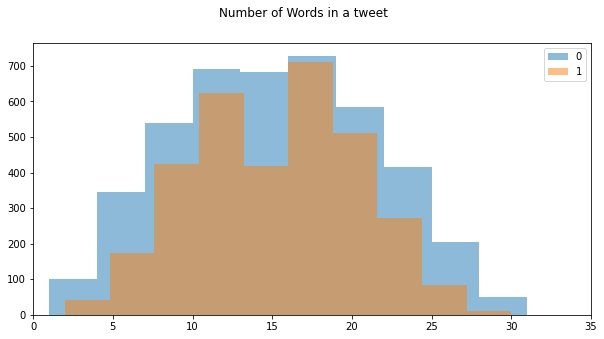

In [0]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
tweet_len0=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax.hist(tweet_len0,label='0', alpha = 0.5)
ax.hist(tweet_len, label='1',alpha = 0.5)
ax.legend(loc='upper right')
fig.suptitle('Number of Words in a tweet')
plt.xlim(xmin=0, xmax = 35)
plt.show()

Another feature we looked at is the length of words in each tweet. Again, to see if lengthy words can be of representative of either of the class in tweets- Although disaster tweets look slighty shorter, we did not find it a very distinctive pattern for a feature.

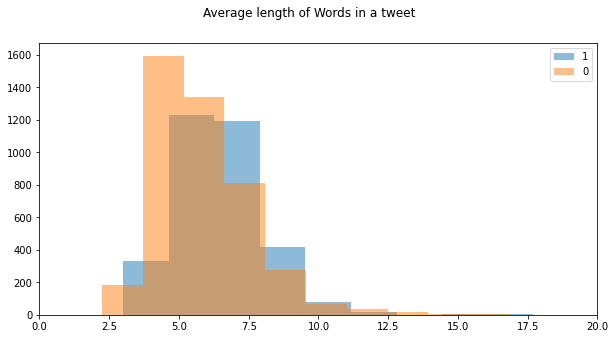

In [0]:
def mean_word_len(x):
  y = x.split()
  sum = 0
  for i in range(0,len(y)):
    sum += len(y[i])
  return sum/len(y)


fig,ax=plt.subplots(1,1,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].map(lambda x: mean_word_len(x))
tweet_len1=train[train['target']==0]['text'].map(lambda x: mean_word_len(x))
ax.hist(tweet_len, label='1',alpha = 0.5)
ax.hist(tweet_len1,label='0', alpha = 0.5)
ax.legend(loc='upper right')
fig.suptitle('Average length of Words in a tweet')
plt.xlim(xmin=0, xmax = 20)
plt.show()

We further employed POS tagging to extract percentage of POS compared to length of tweet and generated histogram for main POS.It appears below that, while there are relatively more nouns in disaster tweets, adjectives and verbs are more present in non disaster tweets. It is worth to try to incorporate it as a feature.

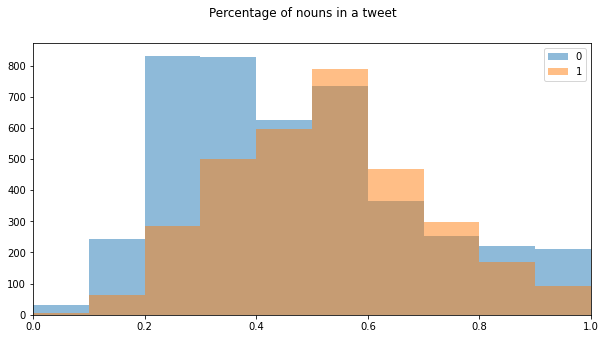

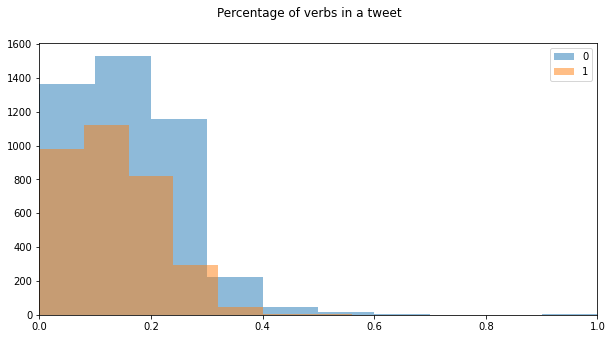

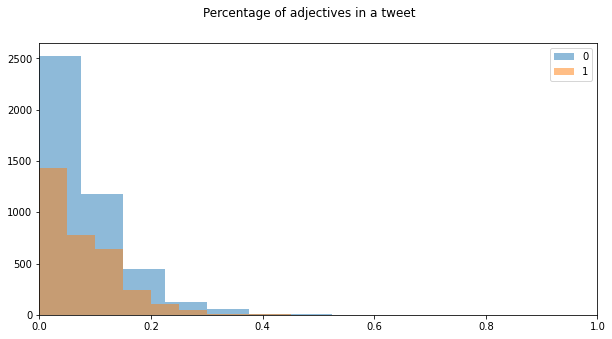

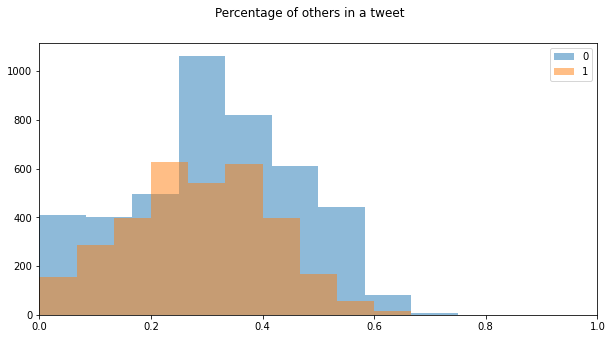

In [0]:
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: nltk.pos_tag(x))
a = []
noun = 0
adj = 0
vb = 0
others = 0
for i in range(0,len(tweet_len)):
    r = len(tweet_len[tweet_len.index[i]])
    for j in range(0,r):
        if tweet_len[tweet_len.index[i]][j][1] in ['NN','NNS','NNP','NNPS']: noun +=1
        elif tweet_len[tweet_len.index[i]][j][1] in ['JJ','JJR','JJS']: adj +=1
        elif tweet_len[tweet_len.index[i]][j][1] in ['VB','VBD','VBG','VBN','VBP','VBZ']: vb +=1
        else: others +=1
    a.append([noun/r,vb/r,adj/r,others/r])
    noun = 0
    adj = 0
    vb = 0
    others = 0
tweet_len0=train[train['target']==0]['text'].str.split().map(lambda x: nltk.pos_tag(x))
b = []
noun = 0
adj = 0
vb = 0
others = 0
for i in range(0,len(tweet_len0)):
    s = len(tweet_len0[tweet_len0.index[i]])
    for j in range(0,s):
        if tweet_len0[tweet_len0.index[i]][j][1] in ['NN','NNS','NNP','NNPS']: noun +=1
        elif tweet_len0[tweet_len0.index[i]][j][1] in ['JJ','JJR','JJS']: adj +=1
        elif tweet_len0[tweet_len0.index[i]][j][1] in ['VB','VBD','VBG','VBN','VBP','VBZ']: vb +=1
        else: others +=1
    b.append([noun/s,vb/s,adj/s,others/s])
    noun = 0
    adj = 0
    vb = 0
    others = 0
    
fig,ax=plt.subplots(1,1,figsize=(10,5))
nouns1 = [a[i][0] for i in range(0,len(a))]
nouns0 = [b[i][0] for i in range(0,len(b))]
ax.hist(nouns0,label = '0',alpha = 0.5)
ax.hist(nouns1,label = '1',alpha = 0.5)
ax.legend(loc='upper right')
plt.xlim(xmin=0, xmax = 1)
fig.suptitle('Percentage of nouns in a tweet')

fig1,ax1=plt.subplots(1,1,figsize=(10,5))
vb1 = [a[i][1] for i in range(0,len(a))]
vb0 = [b[i][1] for i in range(0,len(b))]
ax1.hist(vb0,label = '0',alpha = 0.5)
ax1.hist(vb1,label = '1',alpha = 0.5)
ax1.legend(loc='upper right')
plt.xlim(xmin=0, xmax = 1)
fig1.suptitle('Percentage of verbs in a tweet')

fig2,ax2=plt.subplots(1,1,figsize=(10,5))
adj1 = [a[i][2] for i in range(0,len(a))]
adj0 = [b[i][2] for i in range(0,len(b))]
ax2.hist(adj0,label = '0',alpha = 0.5)
ax2.hist(adj1,label = '1',alpha = 0.5)
ax2.legend(loc='upper right')
plt.xlim(xmin=0, xmax = 1)
fig2.suptitle('Percentage of adjectives in a tweet')

fig3,ax3=plt.subplots(1,1,figsize=(10,5))
oth1 = [a[i][3] for i in range(0,len(a))]
oth0 = [b[i][3] for i in range(0,len(b))]
ax3.hist(oth0,label = '0',alpha = 0.5)
ax3.hist(oth1,label = '1',alpha = 0.5)
ax3.legend(loc='upper right')
plt.xlim(xmin=0, xmax = 1)
fig3.suptitle('Percentage of others in a tweet')

plt.show()

In [6]:
#Collecting the hashtags
def hashtag(x):
    hashtags = []    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

#Extracting hashtags from tweets
HT_non_disaster = hashtag(train['text'][train['target'] == 0])
#Extracting hashtags from racist/sexist tweets
HT_disaster = hashtag(train['text'][train['target'] == 1])
#list
HT_non_disaster = sum(HT_non_disaster,[])
HT_disaster = sum(HT_disaster,[])

Since twitter is famous for hashtags which is a means of highlighting important information, we separated most frequent hashtags in both classes, however we did not find any hashtag worth extracting and keywords already contain most of hashtags that will be used as a text feature.

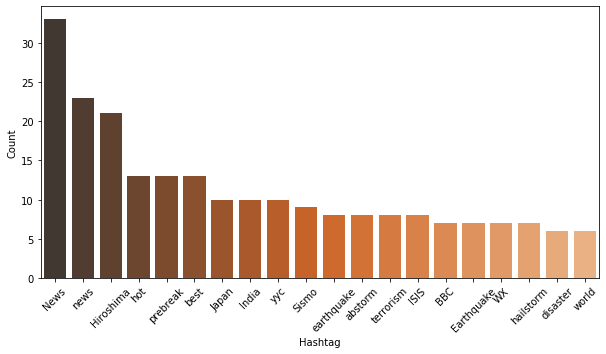

In [7]:
a = nltk.FreqDist(HT_disaster)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 15 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
ax = sns.barplot(data=d, x= "Hashtag", y = "Count", palette="Oranges_d")
ax.set(ylabel = 'Count')
plt.show()

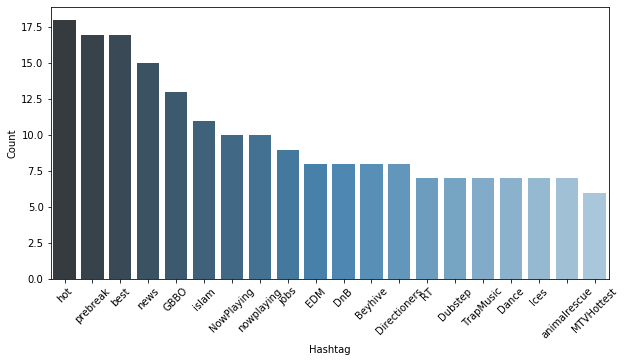

In [8]:
a = nltk.FreqDist(HT_non_disaster)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
ax = sns.barplot(data=d, x= "Hashtag", y = "Count", palette="Blues_d")
ax.set(ylabel = 'Count')
plt.show()


### B. Target correction
Since we know there are plenty duplicates in twitter in the form of replies or forwarded tweets, we decided to check if all duplicate tweets have the same target classification and it appeared that a number of them had divergent classes. We can clearly see below that the same tweets have both target values. We perform class correction on the same.


In [3]:
#Finding duplicate tweets
train[train.text.duplicated(keep = False)].groupby(['text','target']).agg(sum)

id
text                                               target       
#Allah describes piling up #wealth thinking it ... 0       12199
                                                   1        6123
#Bestnaijamade: 16yr old PKK suicide bomber who... 1       54662
#KCA #VoteJKT48ID 12News: UPDATE: A family of 3... 1        8121
#Myanmar  Displaced #Rohingya at #Sittwe point ... 1        8135
...                                                          ...
that exploded &amp; brought about the\nbeginnin... 0        9883
that horrible sinking feeling when youÛªve bee... 0       17416
                                                   1       17437
wowo--=== 12000 Nigerian refugees repatriated f... 0        8044
                                                   1        8018

[87 rows x 1 columns]

In [0]:
#Adjusting target for duplicate texts where target is classed differently
train.loc[train['id'] == 6123, 'target'] = 0
train.loc[train['id'] == 5996, 'target'] = 0
train.loc[train['id'] == 6023, 'target'] = 0
train.loc[train['id'] == 6012, 'target'] = 0
train.loc[train['id'] == 6566, 'target'] = 1
train.loc[train['id'] == 4659, 'target'] = 0
train.loc[train['id'] == 4669, 'target'] = 0
train.loc[train['id'] == 6112, 'target'] = 0
train.loc[train['id'] == 6134, 'target'] = 0
train.loc[train['id'] == 1968, 'target'] = 0
train.loc[train['id'] == 9472, 'target'] = 0
train.loc[train['id'] == 1760, 'target'] = 0
train.loc[train['id'] == 1723, 'target'] = 0
train.loc[train['id'] == 6223, 'target'] = 0
train.loc[train['id'] == 8698, 'target'] = 0
train.loc[train['id'] == 8739, 'target'] = 0
train.loc[train['id'] == 8018, 'target'] = 0
train.loc[train['id'] == 881, 'target'] = 0
train.loc[train['id'] == 907, 'target'] = 0

### C. Text cleaning
Making text lower case & cleaning punctuation marks as well as special characters using regular expressions.


In [5]:
def  clean_text(data, text_field):
    data[text_field] = data[text_field].str.lower()
    data[text_field] = data[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return data

print(train['text'][0:5])
train_clean1 = clean_text(train, "text")
print()
print(train_clean1['text'][0:5])

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object


Further text cleaning below such as mapping apostrophes and repeated letters & characters.

In [6]:
def text_cleaner(text_field):
    text_field = text_field.apply(lambda x: re.sub("’", "'", str(x)))
    text_field = text_field.apply(lambda x: re.sub(r'(.)\1+', r'\1\1', str(x)))
    text_field = text_field.apply(lambda x: ' '.join([apos_mapping[t] if t in apos_mapping else t for t in x.split(" ")]))
    return text_field

apos_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                   "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }

print(train_clean1['text'][30:35])
train_clean = text_cleaner(train_clean1['text'])
print()
print(train_clean[30:35])

30                                              the end
31                            wholesale markets ablaze 
32           we always try to bring the heavy metal rt 
33    africanbaze breaking newsnigeria flag set abla...
34                    crying out for more set me ablaze
Name: text, dtype: object

30                                              the end
31                            wholesale markets ablaze 
32           we always try to bring the heavy metal rt 
33    africanbaze breaking newsnigeria flag set abla...
34                    crying out for more set me ablaze
Name: text, dtype: object


## 2. Bag of words and Baseline

### A.TF-IDF vectorizer
We decided to apply tf-idf vectorizer instead of simple count vectorizer since it calculates the importance of words against the whole corpus. It is simple way of vectorizing the words for baseline since does not consider sequence of those.

In [39]:
#Using both unigrams and bigrams, limiting total features to 100
vectorizer = TfidfVectorizer(max_features = 100,ngram_range = (1,1),stop_words = stopwords.words('english'))
tokenized_tweet = vectorizer.fit_transform(train_clean)
new = pd.DataFrame(tokenized_tweet.todense())
new.columns = vectorizer.get_feature_names()
new.head(5)

,accident,amp,another,army,attack,back,best,black,body,bomb,bombing,buildings,burning,california,cant,car,collapse,could,crash,day,dead,death,disaster,dont,emergency,even,families,fatal,fire,fires,first,forest,full,get,go,going,good,got,help,hiroshima,...,new,news,northern,nuclear,obama,one,people,please,pm,police,read,really,right,say,school,see,still,storm,suicide,take,think,time,today,train,two,us,via,video,want,war,watch,water,way,wildfire,work,world,would,year,years,youre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.667168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.612587,0.0,0.0,0.790403,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.742445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.669907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.671818,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.740717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Combining below the dataframe of 100 words calculated by Tfidf with keywords which we consider important feature.

In [40]:
conc = pd.concat([new,train.loc[:,'keyword']],axis=1)
conc.loc[conc['keyword'].isna(),'keyword'] = 'na'
conc['keyword'] = conc['keyword'].astype('category')
conc = pd.get_dummies(conc,drop_first=True,prefix = ['cat'])
conc.head(5)

,accident,amp,another,army,attack,back,best,black,body,bomb,bombing,buildings,burning,california,cant,car,collapse,could,crash,day,dead,death,disaster,dont,emergency,even,families,fatal,fire,fires,first,forest,full,get,go,going,good,got,help,hiroshima,...,cat_snowstorm,cat_storm,cat_stretcher,cat_structural%20failure,cat_suicide%20bomb,cat_suicide%20bomber,cat_suicide%20bombing,cat_sunk,cat_survive,cat_survived,cat_survivors,cat_terrorism,cat_terrorist,cat_threat,cat_thunder,cat_thunderstorm,cat_tornado,cat_tragedy,cat_trapped,cat_trauma,cat_traumatised,cat_trouble,cat_tsunami,cat_twister,cat_typhoon,cat_upheaval,cat_violent%20storm,cat_volcano,cat_war%20zone,cat_weapon,cat_weapons,cat_whirlwind,cat_wild%20fires,cat_wildfire,cat_windstorm,cat_wounded,cat_wounds,cat_wreck,cat_wreckage,cat_wrecked
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.612587,0.0,0.0,0.790403,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.742445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.671818,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### B. Baseline Model - Naive Bayes

We consider NB a good choice for strong baseline model for text classification problems since it assumes features are independent of each other given the target class.

In [0]:
X_train,X_test,y_train,y_test = train_test_split(conc,train['target'],test_size=0.2,random_state = 1)
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
#Create a Gaussian Classifier
gmodel = GaussianNB()
# Train the model using the training sets
gmodel.fit(X_train,y_train)
#Predict Output
predictions = gmodel.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       886
           1       0.72      0.69      0.70       637

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



### C. Tuning hyperparameters

In [0]:
#Function to execute all of the tf-idf process

def pep_tfidf(train, max_features = 300, ngram_range = (1,2)):
    train1 = clean_text(train,'text')
    train1['text'] = text_cleaner(train1['text'])    
    vectorizer = TfidfVectorizer(max_features = 300,ngram_range = (1,2),stop_words = stopwords.words('english'))
    tokenized_tweet = vectorizer.fit_transform(train1['text'])    
    new = pd.DataFrame(tokenized_tweet.todense())
    new.columns = vectorizer.get_feature_names()
    conc = pd.concat([new,train.loc[:,'keyword']],axis=1)
    conc.loc[conc['keyword'].isna(),'keyword'] = 'na'
    conc['keyword'] = conc['keyword'].astype('category')
    conc = pd.get_dummies(conc,drop_first=True,prefix = ['cat'])
    return conc

pep_tfidf(train).head(5)

,2015,40,70,accident,air,also,always,ambulance,amp,another,area,army,around,ass,atomic,attack,attacked,back,bad,bag,bags,best,big,black,blood,bloody,boat,body,bomb,bomber,bombing,boy,breaking,bridge,buildings,burned,burning,burning buildings,bus,california,...,cat_snowstorm,cat_storm,cat_stretcher,cat_structural%20failure,cat_suicide%20bomb,cat_suicide%20bomber,cat_suicide%20bombing,cat_sunk,cat_survive,cat_survived,cat_survivors,cat_terrorism,cat_terrorist,cat_threat,cat_thunder,cat_thunderstorm,cat_tornado,cat_tragedy,cat_trapped,cat_trauma,cat_traumatised,cat_trouble,cat_tsunami,cat_twister,cat_typhoon,cat_upheaval,cat_violent%20storm,cat_volcano,cat_war%20zone,cat_weapon,cat_weapons,cat_whirlwind,cat_wild%20fires,cat_wildfire,cat_windstorm,cat_wounded,cat_wounds,cat_wreck,cat_wreckage,cat_wrecked
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.561682,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
from sklearn.metrics import accuracy_score
# 5-fold cross validation
max_feat = [100,200,300,400,500] ## max features
ngram_ra = [(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]  ## combinations of n-grams
folds = 5## no. of folds
b = 0
a = 0
state = []
for feat in max_feat:
    for ra in ngram_ra:
        for i in range(0,folds):
            new = pep_tfidf(train,max_features = feat,ngram_range = ra)
            X_train,X_test,y_train,y_test = train_test_split(new,train['target'],test_size=0.2,random_state = 11*i)
            gmodel = GaussianNB()
            # Train the model using the training sets
            gmodel.fit(X_train,y_train)
            #Predict Output
            predictions_NB = gmodel.predict(X_test)
            b += accuracy_score(y_test,predictions_NB)
            
        if (b)>a:
            a = b
            state = [feat,ra]
        b = 0

print("Best combination of features is :", state)
        
        

Best combination of features is : [100, (1, 1)]


### D. Adding POS information as a feature

In [0]:
def count_pos(arr):
  noun = 0
  vb = 0
  adj = 0
  oth = 0
  a = []
  for i in arr:
    if i[1] in ['NN','NNS','NNP','NNPS']: noun +=1
    elif i[1] in ['JJ','JJR','JJS']: adj +=1
    elif i[1] in ['VB','VBD','VBG','VBN','VBP','VBZ']: vb +=1
    else: oth +=1
  return ([noun/(len(arr)),vb/(len(arr)),adj/(len(arr)),oth/(len(arr))])

train_pos = train_clean.str.split().apply(nltk.pos_tag).apply(count_pos)

Combining POS feature with TFIDF vectors

In [37]:
posdf = pd.DataFrame(np.zeros([len(train_pos),len(train_pos[0])]))
for i in range(0,len(train_pos)):
  for j in range(0,len(train_pos[0])):
    posdf.iloc[i,j] = train_pos[i][j]
posdf.columns = ['nouns','verbs','adjs','others']
posdf.head(5)

,nouns,verbs,adjs,others
0,0.230769,0.153846,0.076923,0.538462
1,0.571429,0.000000,0.285714,0.142857
2,0.318182,0.318182,0.045455,0.318182
3,0.500000,0.125000,0.125000,0.250000
4,0.312500,0.187500,0.062500,0.437500


Testing perfromance using Naive Bayes

In [46]:
conc = pd.concat([posdf,new,train.loc[:,'keyword']],axis=1)
conc.loc[conc['keyword'].isna(),'keyword'] = 'na'
conc['keyword'] = conc['keyword'].astype('category')
conc = pd.get_dummies(conc,drop_first=True,prefix = ['cat'])

X_train,X_test,y_train,y_test = train_test_split(conc,train['target'],test_size=0.2,random_state = 1)
#Create a Gaussian Classifier
gmodel = GaussianNB()
# Train the model using the training sets
gmodel.fit(X_train,y_train)
#Predict Output
predictions = gmodel.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       886
           1       0.72      0.69      0.70       637

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



## 3. Advanced feature extraction, word embedding and modelling
### A. Tokenizing
Tokenizing the tweet using NLTK tweet tokenizer to be able to extract words from text

In [0]:
from nltk.tokenize import TweetTokenizer
train_clean.columns = ['text']
train_clean = pd.DataFrame(train_clean)
tweet_tokenizer = TweetTokenizer()
train_clean['tokenized'] = train_clean['text'].apply(lambda row: tweet_tokenizer.tokenize(row))
train_clean.head(5)

,text,tokenized
0,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth..."
1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place..."
3,1300 people receive wildfires evacuation order...,"[1300, people, receive, wildfires, evacuation,..."
4,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala..."


### B. Removing stopwords
Removing stopwords from words using default english stopwords.

In [0]:
import nltk
from nltk.corpus import stopwords  
stop_words = set(stopwords.words('english')) 
  
def sw(text):
    sw_out_text = [word for word in text if not word in stop_words]
    return sw_out_text

train_clean['tokenized']= train_clean['tokenized'].apply(lambda x: sw(x))


### C. Stemming
Stemming tokenized words to keep only the root level of the word as a feature. We tried different kind of stemmers, however decided to keep snowballstemmer as a form of less agressive trimming algorithm.

In [0]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')

def stemming(text):
    out_text = [stemmer.stem(word) for word in text]
    return out_text
    
train_clean['stemmed']= train_clean['tokenized'].apply(lambda x: stemming(x))
train_clean.head(5)

,text,tokenized,stemmed
0,our deeds are the reason of this earthquake ma...,"[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]"
1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]"
2,all residents asked to shelter in place are be...,"[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev..."
3,1300 people receive wildfires evacuation order...,"[1300, people, receive, wildfires, evacuation,...","[1300, peopl, receiv, wildfir, evacu, order, c..."
4,just got sent this photo from ruby alaska as s...,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi..."


### D. Word2Vec embedding
As a word embedding, we decided to try word2vec representation of clean tweet vocabulary. Word2Vec is able to capture the context of a word within semantic and syntactic similarity in relation with other words. In other words, representing the word into a vector considering the sequence of words, trained on given tweets and not pre-trained. The desired number features is set to 200 with skip gram model of 1.

In [0]:
import gensim
from gensim.models import Word2Vec
tokenized_tweet=train_clean['stemmed']
model1=Word2Vec(tokenized_tweet, size = 200, window = 9, min_count = 2, sg=1, hs = 0, negative = 10, workers = 32, seed = 34)
model1.train(tokenized_tweet, total_examples = len(train.text), epochs=20)


(1212109, 1379620)

In [0]:
def word_vector(tokens, size,model):
    vec=np.zeros(size).reshape((1,size))
    count=0
    for word in tokens:
        try:
            vec+=model[word].reshape((1,size))
            count+=1.
        except KeyError:
            continue
    if count!=0:
        vec/=count
    return vec

wordvec_arrays=np.zeros((len(tokenized_tweet),200))
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i],200,model1)
wordvec_df=pd.DataFrame(wordvec_arrays)
wordvec_df.head(3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,-0.001986,0.034503,-0.183734,-0.099223,-0.083351,-0.188836,-0.045097,-0.016664,0.011160,0.006809,0.104310,0.118272,0.002880,0.318505,-0.005828,-0.116106,0.012691,-0.455021,-0.041934,-0.091894,0.028392,0.023995,-0.082929,0.048620,0.270884,0.037941,-0.320593,0.055516,0.024797,-0.156851,0.113746,-0.124594,0.011469,-0.174429,-0.237471,-0.265678,-0.118821,0.024619,0.070082,-0.171407,...,-0.013131,-0.111540,0.047979,0.087542,-0.007445,-0.353288,0.049902,0.014789,-0.063994,0.070185,0.178071,-0.283767,-0.200178,-0.193847,0.147392,0.142853,0.329785,-0.069265,-0.055860,0.061010,-0.068285,-0.111561,-0.183174,-0.198216,0.008256,0.129665,-0.239464,0.054154,0.135390,-0.356196,-0.012354,-0.243355,-0.386949,-0.379699,-0.155815,0.183427,-0.508331,0.181623,0.201537,0.198730
1,0.294795,-0.139817,-0.191550,-0.065632,-0.284501,0.119078,-0.228162,0.196798,0.138750,-0.141611,0.005303,0.050218,-0.298789,0.185914,-0.196221,-0.012662,0.119176,-0.216859,0.119319,-0.278114,0.090720,0.191460,-0.117287,-0.053595,0.192126,-0.056185,0.037738,0.041082,-0.256544,-0.324723,0.172971,-0.297699,0.349487,0.220732,-0.058603,0.110655,0.173179,-0.023875,0.289341,-0.422075,...,-0.127664,-0.102861,-0.412759,0.005845,-0.071878,-0.169743,-0.021535,0.146977,-0.385024,0.232157,-0.008252,-0.043150,0.082867,-0.019742,0.108094,0.162719,0.263406,-0.120304,-0.465290,0.210335,0.266048,0.289415,-0.059488,0.031285,0.212795,0.392778,-0.306101,0.267507,0.200062,-0.653907,0.007010,-0.017227,0.001376,-0.105673,-0.294557,-0.022699,-0.290378,0.149180,0.070685,0.223170
2,0.189829,0.263924,-0.202253,-0.086964,-0.165238,0.304148,-0.128142,0.163659,0.201596,-0.066098,0.085343,0.127580,-0.110038,0.099830,-0.129696,-0.050960,-0.260961,-0.365723,0.188559,-0.048441,0.149372,0.051499,-0.520235,0.036314,-0.049698,-0.017890,-0.317124,0.059680,-0.136110,-0.186245,0.258916,-0.413802,0.242907,0.046753,-0.057172,-0.001558,0.104527,0.030811,-0.171501,-0.132516,...,0.092819,0.080601,-0.319976,-0.080086,-0.249383,-0.040522,-0.159788,0.097622,-0.310676,0.113000,-0.182248,0.238791,-0.079514,0.144349,0.041806,0.192549,0.144947,0.025559,-0.252045,0.050792,0.309830,0.215508,0.358098,-0.009412,0.084618,0.236018,0.107212,0.156532,0.108169,-0.049447,0.084729,-0.169653,-0.325526,-0.222186,-0.136535,0.013481,0.012503,0.040918,-0.073811,0.107564



As mentioned, we consider keyword as an important feature, so below we perform one hot encoding of keywords and joining with word vectors trained by Word2Vec.

In [0]:
conc = pd.concat([wordvec_df,train['keyword']],axis = 1)
conc.loc[conc['keyword'].isna(),'keyword'] = 'na'
conc = pd.get_dummies(conc,prefix=['cat'], drop_first= False)
conc.head(3)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,cat_snowstorm,cat_storm,cat_stretcher,cat_structural%20failure,cat_suicide%20bomb,cat_suicide%20bomber,cat_suicide%20bombing,cat_sunk,cat_survive,cat_survived,cat_survivors,cat_terrorism,cat_terrorist,cat_threat,cat_thunder,cat_thunderstorm,cat_tornado,cat_tragedy,cat_trapped,cat_trauma,cat_traumatised,cat_trouble,cat_tsunami,cat_twister,cat_typhoon,cat_upheaval,cat_violent%20storm,cat_volcano,cat_war%20zone,cat_weapon,cat_weapons,cat_whirlwind,cat_wild%20fires,cat_wildfire,cat_windstorm,cat_wounded,cat_wounds,cat_wreck,cat_wreckage,cat_wrecked
0,-0.001986,0.034503,-0.183734,-0.099223,-0.083351,-0.188836,-0.045097,-0.016664,0.011160,0.006809,0.104310,0.118272,0.002880,0.318505,-0.005828,-0.116106,0.012691,-0.455021,-0.041934,-0.091894,0.028392,0.023995,-0.082929,0.048620,0.270884,0.037941,-0.320593,0.055516,0.024797,-0.156851,0.113746,-0.124594,0.011469,-0.174429,-0.237471,-0.265678,-0.118821,0.024619,0.070082,-0.171407,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.294795,-0.139817,-0.191550,-0.065632,-0.284501,0.119078,-0.228162,0.196798,0.138750,-0.141611,0.005303,0.050218,-0.298789,0.185914,-0.196221,-0.012662,0.119176,-0.216859,0.119319,-0.278114,0.090720,0.191460,-0.117287,-0.053595,0.192126,-0.056185,0.037738,0.041082,-0.256544,-0.324723,0.172971,-0.297699,0.349487,0.220732,-0.058603,0.110655,0.173179,-0.023875,0.289341,-0.422075,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.189829,0.263924,-0.202253,-0.086964,-0.165238,0.304148,-0.128142,0.163659,0.201596,-0.066098,0.085343,0.127580,-0.110038,0.099830,-0.129696,-0.050960,-0.260961,-0.365723,0.188559,-0.048441,0.149372,0.051499,-0.520235,0.036314,-0.049698,-0.017890,-0.317124,0.059680,-0.136110,-0.186245,0.258916,-0.413802,0.242907,0.046753,-0.057172,-0.001558,0.104527,0.030811,-0.171501,-0.132516,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### E. Hyperparameter tuning for SVM

In [0]:
from sklearn import svm

a = 0
state = []
C = [0.01,0.1,1,10,100]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale','auto']
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
for c in C:
  for kernel in kernels:
    for gam in gamma:
      
      SVM = svm.SVC(C=c, kernel=kernel, degree=2, gamma=gam)
      SVM.fit(X_train,y_train)
      # predict the labels on validation dataset
      predictions_SVM = SVM.predict(X_test)
      b = accuracy_score(y_test,predictions_SVM)

      if b>a: 
        a = b
        state = [c,kernel,gam]

print(state)

[1, 'rbf', 'scale']


### F. SVM
Applying SVM with the best hyperparameters, we achieve accuracy of 82%.

In [0]:
from sklearn import svm
from sklearn.metrics import accuracy_score

X_train,X_test,y_train,y_test = train_test_split(conc,train['target'],test_size=0.2,random_state = 1)
SVM = svm.SVC(C=1, kernel='rbf', degree=2, gamma='scale')
SVM.fit(X_train,y_train)
predictions_SVM = SVM.predict(X_test)
print(round(accuracy_score(y_test,predictions_SVM),2))

0.82


### G.Making Prediction


In [0]:
## Combining all the functions into a single funtion
def pep(train):
    train1 = clean_text(train,'text')
    train1['text'] = text_cleaner(train1['text'])    
    tweet_tokenizer = TweetTokenizer()
    tokenized_tweet=train1['text'].apply(lambda x: tweet_tokenizer.tokenize(x))
    tokenized_tweet = tokenized_tweet.apply(lambda x: sw(x))
    tokenized_tweet = tokenized_tweet.apply(lambda x: stemming(x))
    model1=Word2Vec(tokenized_tweet, size = 200, window = 5, min_count = 2, hs = 0, negative = 10, workers = 32, seed = 34)
    model1.train(tokenized_tweet, total_examples = len(train.text), epochs=20)
    wordvec_arrays=np.zeros((len(tokenized_tweet),200))
    for i in range(len(tokenized_tweet)):
        wordvec_arrays[i,:] = word_vector(tokenized_tweet[i],200,model1)
    wordvec_df=pd.DataFrame(wordvec_arrays)
    conc = pd.concat([wordvec_df,train.loc[:,'keyword']],axis=1)
    conc.loc[conc['keyword'].isna(),'keyword'] = 'na'
    #conc['keyword'] = conc['keyword'].astype('category')
    conc = pd.get_dummies(conc,drop_first=True,prefix = ['cat'])
    return conc

In [0]:
a = pep(train)
b = pep(test)
SVM = svm.SVC(C=1, kernel='rbf', degree=2, gamma='scale')
SVM.fit(a,train['target'])
prediction = SVM.predict(b)
out = pd.concat([test['id'],pd.DataFrame(prediction)],axis = 1)
out.columns = ['id','target']
out.head(5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


## 4. Pre-trained word embedding and modelling

### A. Glove
Since we have tried word embedding trained on our data, we decided to additionally try extracting glove vector as a pre-trained word embedding agorithm. Glove works well at capturing the semantics of analogy in words, co-occurences over the whole corpus.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:

embeddings_dict = {}
with open("/content/gdrive/My Drive/glove.6B.50d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector



In [0]:
def glove_apply(arr):
    temp = np.zeros([50,])
    a = 0
    for i in range(0,len(arr)):
        try:
            temp += embeddings_dict[arr[i]]
        except KeyError:
            a+=1
            continue
    return(temp/(len(arr)-a+1))
        
    

Below we perfom text cleaning, tweet tokenizing in order to apply glove encoding to our data. In addition, we incorporate keyword as a feature for modelling

In [0]:
# Cleaning, splitting and stemming the data
from nltk.tokenize import TweetTokenizer
train1 = clean_text(train,'text')
train1['text'] = text_cleaner(train1['text'])    
tweet_tokenizer = TweetTokenizer()
tokenized_tweet=train1['text'].apply(lambda x: tweet_tokenizer.tokenize(x))
gloved_tweet = tokenized_tweet.apply(lambda x: glove_apply(x))
a = pd.DataFrame([gloved_tweet[i] for i in range(0,len(gloved_tweet))])
conc = pd.concat([a,train['keyword']],axis = 1)
conc.loc[conc['keyword'].isna(),'keyword'] = 'na'
conc = pd.get_dummies(conc, drop_first= False)

### B. SVM
Applications of SVM for glove implementation

In [0]:
X_train,X_test,y_train,y_test = train_test_split(conc,train['target'],test_size=0.2,random_state = 1)
SVM = svm.SVC(C=1, kernel='rbf', degree=2, gamma='scale')
SVM.fit(X_train,y_train)
predictions_SVM = SVM.predict(X_test)
print('SVM')
print(classification_report(y_test, predictions_SVM))

SVM
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       886
           1       0.85      0.68      0.76       637

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.82      0.82      0.81      1523



### C. Neural Network
Application of Neural network for Glove

In [0]:
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
  tf.keras.layers.Dropout(0.2),
  ])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5)
model.evaluate(X_test, y_test)

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

191/191 [==============================] - 0s 1ms/step - loss: 1.7408 - accuracy: 0.7085
Epoch 2/5
191/191 [==============================] - 0s 1ms/step - loss: 1.7736 - accuracy: 0.7525
Epoch 3/5
191/191 [==============================] - 0s 1ms/step - loss: 1.6557 - accuracy: 0.7668
Epoch 4/5
191/191 [==============================] - 0s 1ms/step - loss: 1.7608 - accuracy: 0.7681
Epoch 5/5
48/48 [==============================] - 0s 1ms/step - loss: 0.4624 - accuracy: 0.8076


[0.4624423086643219, 0.8076165318489075]